In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [19]:
## follow the instructions on the website
def unpickle(file):
    ## used to read binary files since our data files are in binary format
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [20]:
## loading data from binary data files
batch_1_dictionary = unpickle('cifar-10-data/data_batch_1')
batch_2_dictionary = unpickle('cifar-10-data/data_batch_2')

In [4]:
batch_1_dictionary.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
## get training, validation and testing sets
X_train_all = np.array(batch_1_dictionary[b'data']).reshape(10000,3,32,32)
y_train_all = np.array(batch_1_dictionary[b'labels'])
validation_count = 1000
train_count = X_train_all.shape[0]-1000
X_train = X_train_all[:train_count]
y_train = y_train_all[:train_count]
X_val = X_train_all[train_count:]
y_val = y_train_all[train_count:]
X_test = np.array(batch_2_dictionary[b'data']).reshape(10000,3,32,32)
y_test = np.array(batch_2_dictionary[b'labels'])

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((9000, 3, 32, 32),
 (9000,),
 (1000, 3, 32, 32),
 (1000,),
 (10000, 3, 32, 32),
 (10000,))

In [7]:
# for RGB data we can simply divide by 255
X_train_normalized =  X_train/255
X_val_normalized =  X_val/255
X_test_normalized = X_test/255

In [8]:
## class label related
CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def index_to_class_name(y):
    return CLASSES[y]
def class_name_to_index(class_name):
    return CLASSES.index(class_name)

In [9]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_single_image(data):
    # show a single image
    ## note that using matplotlib plotting function, we will have to reshape the data as (1,32,32,3)
    img = data.reshape(3,32,32).transpose(1,2,0)
    imgplot = plt.imshow(img)
def show_multiple_images(data, data_y, n_show=12, columns=4):
    ## given an array of data, show all of them as images
    fig=plt.figure(figsize=(8, 8))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n/columns)
    for i in range(n):
        img = data[i].reshape(3,32,32).transpose(1,2,0)
        ax = fig.add_subplot(rows, columns, i+1) ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i])+": "+class_name)
        plt.imshow(img)
    plt.show()

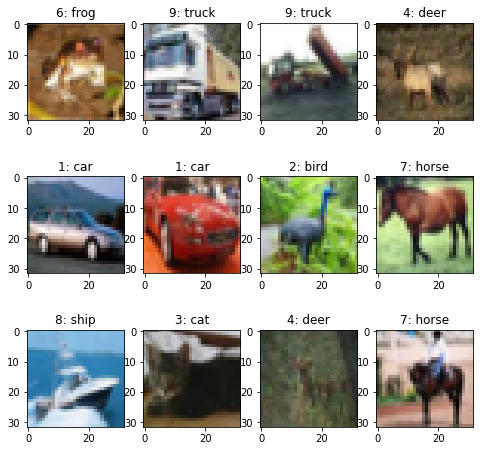

In [10]:
show_multiple_images(X_train, y_train)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

class MLP(nn.Module):
    ## a very simple MLP model
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, output_dim)
        
        # in order to put all of the parameters into a list you have to use nn.Module([]) bc you cant use a normal python list
    def forward(self, x):
        z_1 = self.fc1(x)
        a_1 = F.relu(z_1)
        z_2 = self.fc2(a_1)
        return z_2

In [16]:
# utility for getting prediction accuracy
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _ ,pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct ,correct/n

In [17]:
# init network
mlp = MLP(3072, 10)
print('model structure: ',mlp)
# init optimizer
# lr = learning rate
#optim. takes in the weights and the learning rate so that when you call optimizer.step() you will update the weights
#when you call model.paramters() you get all of the weights between layers
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
# set loss function
criterion = nn.CrossEntropyLoss()

# prepare for mini-batch stochastic gradient descent
n_iteration = 100
batch_size = 256
n_train_data = X_train_normalized.shape[0]
print(n_train_data)
n_test_data = X_test_normalized.shape[0]
n_batch = int(np.ceil(n_train_data/batch_size))

# convert X_train and X_val to tensor and flatten them
# the -1 means that the dimensions will be computed automatically
X_train_tensor = Tensor(X_train_normalized).reshape(n_train_data, -1)
X_val_tensor = Tensor(X_val_normalized).reshape(1000, -1)
X_test_tensor = Tensor(X_test_normalized).reshape(n_test_data, -1)

# convert training label to tensor and to type long
y_train_tensor = Tensor(y_train).long()
y_val_tensor = Tensor(y_val).long()
y_test_tensor = Tensor(y_test).long()

X_train_tensor.shape

model structure:  MLP(
  (fc1): Linear(in_features=3072, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
9000


torch.Size([9000, 3072])

In [16]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
train_loss_sum = 0
ave_train_loss = 0
train_acc_sum = 0
ave_train_acc = 0
val_loss_sum = 0
ave_val_loss = 0
val_acc_sum = 0
ave_val_acc = 0

for i in range(n_iteration):
    # first get a minibatch of data
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]
        
        y_pred = mlp(X_batch)
        # criterion is a loss function given by pytorch

        loss = criterion(y_pred, y_batch)
        #assigns the parameters in the model and sets their gradient to zero
        optimizer.zero_grad()
        #
        loss.backward()
        # 
        optimizer.step()
        
        
        correct, train_acc = get_correct_and_accuracy(y_pred, y_batch)


#     print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f"%(i ,ave_train_loss, train_acc, val_loss, val_acc)) 
    
    ## add to the logs so that we can use them later for plotting
    train_loss_sum += loss.item()
    ave_train_loss = train_loss_sum / (i+1)
    
    train_acc_sum += train_acc
    ave_train_acc = train_acc_sum / (i+1)
    
    val_pred = mlp.forward(X_val_tensor)
    val_loss = criterion(val_pred, y_val_tensor)
    val_correct, val_acc = get_correct_and_accuracy(val_pred, y_val_tensor)
    
    val_loss_sum += val_loss.item()
    ave_val_loss = val_loss_sum / (i+1)
    
    val_acc_sum += val_acc
    ave_val_acc = val_acc_sum / (i+1)
    
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = ave_train_acc
    val_loss_list[i] = ave_val_loss
    val_accu_list[i] = ave_val_acc 
    

Iter 0 ,Train loss: 77.475, Train acc: 0.275, Val loss: 2.040, Val acc: 0.227
Iter 1 ,Train loss: 35.655, Train acc: 0.325, Val loss: 1.940, Val acc: 0.291
Iter 2 ,Train loss: 22.970, Train acc: 0.400, Val loss: 1.899, Val acc: 0.330
Iter 3 ,Train loss: 16.879, Train acc: 0.375, Val loss: 1.875, Val acc: 0.340
Iter 4 ,Train loss: 13.298, Train acc: 0.375, Val loss: 1.858, Val acc: 0.335
Iter 5 ,Train loss: 10.937, Train acc: 0.400, Val loss: 1.842, Val acc: 0.338
Iter 6 ,Train loss: 9.275, Train acc: 0.450, Val loss: 1.833, Val acc: 0.345
Iter 7 ,Train loss: 8.045, Train acc: 0.425, Val loss: 1.823, Val acc: 0.343
Iter 8 ,Train loss: 7.094, Train acc: 0.450, Val loss: 1.812, Val acc: 0.349
Iter 9 ,Train loss: 6.337, Train acc: 0.450, Val loss: 1.806, Val acc: 0.355
Iter 10 ,Train loss: 5.726, Train acc: 0.425, Val loss: 1.800, Val acc: 0.360
Iter 11 ,Train loss: 5.217, Train acc: 0.425, Val loss: 1.789, Val acc: 0.368
Iter 12 ,Train loss: 4.789, Train acc: 0.425, Val loss: 1.785, Val a

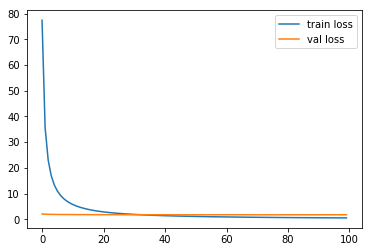

In [17]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

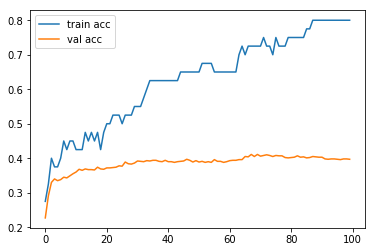

In [18]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [19]:
## test performance on the test set and report final performance
test_pred = mlp.forward(X_test_tensor)
test_correct, test_acc = get_correct_and_accuracy(test_pred, y_test_tensor)
#     print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f"%(i ,ave_train_loss, train_acc, val_loss, val_acc)) 
print("Test accuracy:", (test_acc))

Test accuracy: 0.3812


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(10, 18, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(-1, 18 * 16 *16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [12]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)
# init optimizer
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)
# set loss function
criterion = nn.CrossEntropyLoss()

# prepare for mini-batch stochastic gradient descent
n_iteration = 40
batch_size = 256
n_data = X_train_normalized.shape[0]
print()
n_batch = int(np.ceil(n_data/batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = Tensor(X_train_normalized)
X_val_tensor = Tensor(X_val_normalized)
X_test_tensor = Tensor(X_test_normalized)

# convert training label to tensor and to type long
y_train_tensor = Tensor(y_train).long()
y_val_tensor = Tensor(y_val).long()
y_test_tensor = Tensor(y_test).long()

print('X train tensor shape:', X_train_tensor.shape)

model structure:  ConvNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
X train tensor shape: torch.Size([9000, 3, 32, 32])


In [13]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
train_loss_sum = 0
ave_train_loss = 0
train_acc_sum = 0
ave_train_acc = 0
val_loss_sum = 0
ave_val_loss = 0
val_acc_sum = 0
ave_val_acc = 0

for i in range(n_iteration):
    # first get a minibatch of data
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]
        
        y_pred = conv_net.forward(X_batch)
        
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        correct, train_acc = get_correct_and_accuracy(y_pred, y_batch)
        
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f"%(i ,ave_train_loss, train_acc, val_loss, val_acc)) 
    
    train_loss_sum += loss.item()
    ave_train_loss = train_loss_sum / (i+1)
    
    train_acc_sum += train_acc
    ave_train_acc = train_acc_sum / (i+1)

    val_pred = conv_net.forward(X_val_tensor)
    val_loss = criterion(val_pred, y_val_tensor)
    val_correct, val_acc = get_correct_and_accuracy(val_pred, y_val_tensor)
    
    val_loss_sum += val_loss.item()
    ave_val_loss = val_loss_sum / (i+1)
    
    val_acc_sum += val_acc
    ave_val_acc = val_acc_sum / (i+1)
    
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = ave_train_acc
    val_loss_list[i] = ave_val_loss
    val_accu_list[i] = ave_val_acc  

NameError: name 'get_correct_and_accuracy' is not defined

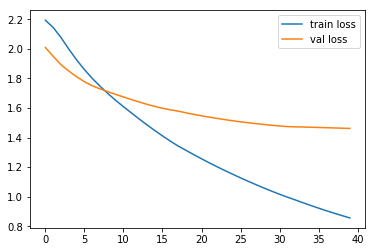

In [21]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

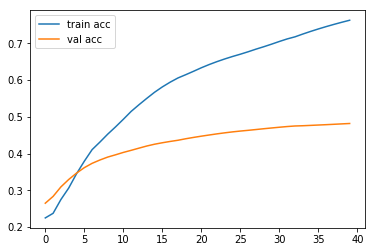

In [22]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [23]:
## test performance on the test set and report final performance
test_pred = conv_net.forward(X_test_tensor)
test_correct, test_acc = get_correct_and_accuracy(test_pred, y_test_tensor)
print("Test accuracy:", (test_acc))

Test accuracy: 0.517
